# Lab | Clustering the songs from the databases

Now it's time to cluster the songs of the hot_songs and not_hot_songs databases according to the song's audio features. You will need to consider the following:

- Are you going to use all the audio features? If not, which ones do you think to make more sense?
- What is the optimal number of clusters (for methods that need to know this beforehand)?
- What is the best distance to use?
- What clustering method provides better results?
- Does the clustering method need a transformer?

Be aware that this process is extremely time-consuming!!! Therefore, when testing different options, save the models into your disk in order to be able to use the best model later.  You don't want to retrain the best model again when you know what are the optimal parameters for each.

Add to the hot_songs and not_hot_songs databases a new column for each clustering method with the cluster membership of each song for each method.

## Importing the libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pickle

In [2]:
all_songs = pd.read_csv('/Users/Hector_Martin/Documents/Labs/music_recommender_project/data/allsongs_df.csv')

## Removing all the unnecessary audio features:
These are not actually audio features, just links and other kind of information that has nothing to do with audio qualities.

In [3]:
all_songs_clean = all_songs.drop(['analysis_url', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'time_signature', 'type'],axis =1)

## Store this cleaned Dataframe in a csv file:

In [4]:
all_songs_clean.to_csv("data/all_songs_clean.csv", index=False)

## Numerical and Categorical split:
- X_num will be for Numerical columns
- X_cat will be for Categorical ones

In [5]:
X_num = all_songs_clean.drop(['songs', 'artists'], axis =1)

In [7]:
X_cat = all_songs[['songs', 'artists']]

## Checking the Data types per column

In [12]:
X_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4163 entries, 0 to 4162
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      4163 non-null   float64
 1   energy            4163 non-null   float64
 2   key               4163 non-null   int64  
 3   loudness          4163 non-null   float64
 4   mode              4163 non-null   int64  
 5   speechiness       4163 non-null   float64
 6   acousticness      4163 non-null   float64
 7   instrumentalness  4163 non-null   float64
 8   liveness          4163 non-null   float64
 9   valence           4163 non-null   float64
 10  tempo             4163 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 357.9 KB


In [13]:
X_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4163 entries, 0 to 4162
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   songs    4163 non-null   object
 1   artists  4163 non-null   object
dtypes: object(2)
memory usage: 65.2+ KB


## Scaling the features

In [17]:
scaler = StandardScaler()
scaler.fit(X_num)#We will not use all the X, only the numerical features, select the appropriate num features
X_scaled = scaler.transform(X_num)
filename = "/Users/Hector_Martin/Documents/Labs/music_recommender_project/scalers/standardscaler.pickle" # Path with filename
with open(filename, "wb") as file:
        pickle.dump(scaler,file)
X_scaled_df = pd.DataFrame(X_scaled, columns = X_num.columns)
display(X_num.describe())
display(X_scaled_df.describe())
display(X_num.head())#data before the transformation
print()
display(X_scaled_df.head())#data after the transformation

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000
mean,0.603720,0.605580,5.178237,-8.844525,0.711266,0.078743,0.306591,0.057846,0.183908,0.585401,120.043639
std,0.156682,0.218628,3.586032,4.191864,0.453228,0.091392,0.295644,0.192741,0.150528,0.245755,28.771655
min,0.070700,0.004580,0.000000,-37.406000,0.000000,0.022400,0.000005,0.000000,0.018800,0.000010,37.114000
25%,0.508000,0.455000,2.000000,-11.174500,0.000000,0.032700,0.046050,0.000000,0.091950,0.391000,98.162500
50%,0.612000,0.627000,5.000000,-8.153000,1.000000,0.042600,0.204000,0.000007,0.126000,0.605000,118.394000
75%,0.713500,0.775000,8.000000,-5.775500,1.000000,0.073750,0.535000,0.001120,0.235000,0.791000,136.970500
max,0.988000,1.000000,11.000000,0.915000,1.000000,0.964000,0.996000,0.987000,0.989000,0.984000,209.819000


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,4.163000e+03,4.163000e+03,4.163000e+03,4.163000e+03,4.163000e+03,4.163000e+03,4.163000e+03,4.163000e+03,4.163000e+03,4.163000e+03,4.163000e+03
mean,6.626669e-16,-1.506255e-16,4.333683e-17,3.023711e-16,4.069662e-17,-1.280103e-18,1.773477e-17,9.120737e-17,1.424115e-17,-2.246581e-16,2.969840e-16
std,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00
min,-3.402326e+00,-2.749298e+00,-1.444175e+00,-6.814368e+00,-1.569520e+00,-6.165686e-01,-1.037135e+00,-3.001580e-01,-1.096988e+00,-2.382296e+00,-2.882684e+00
25%,-6.109931e-01,-6.888347e-01,-8.863889e-01,-5.558993e-01,-1.569520e+00,-5.038535e-01,-8.813730e-01,-3.001580e-01,-6.109746e-01,-7.911307e-01,-7.606016e-01
50%,5.285024e-02,9.798564e-02,-4.970906e-02,1.649883e-01,6.371373e-01,-3.955157e-01,-3.470513e-01,-3.001208e-01,-3.847441e-01,7.975976e-02,-5.734246e-02
75%,7.007358e-01,7.750171e-01,7.869708e-01,7.322265e-01,6.371373e-01,-5.463470e-02,7.726730e-01,-2.943464e-01,3.394594e-01,8.367019e-01,5.883879e-01
max,2.452899e+00,1.804288e+00,1.623651e+00,2.328486e+00,6.371373e-01,9.687559e+00,2.332168e+00,4.821313e+00,5.349087e+00,1.622131e+00,3.120646e+00


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.761,0.525,11,-6.900,1,0.0944,0.44000,0.000007,0.0921,0.531,80.870
1,0.591,0.764,1,-5.484,1,0.0483,0.03830,0.000000,0.1030,0.478,169.928
2,0.825,0.414,2,-6.634,1,0.1440,0.00265,0.000000,0.3570,0.106,72.993
3,0.695,0.540,4,-5.692,1,0.0493,0.29900,0.000000,0.3670,0.415,121.932
4,0.577,0.450,0,-8.516,0,0.0834,0.35700,0.000000,0.1110,0.830,205.863


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,1.003933,-0.368617,1.623651,0.463937,0.637137,0.171343,0.451302,-0.300123,-0.609978,-0.221389,-1.361699
1,-0.081195,0.724697,-1.165282,0.801774,0.637137,-0.333139,-0.907590,-0.300158,-0.537558,-0.437077,1.734011
2,1.412452,-0.876391,-0.886389,0.527400,0.637137,0.714126,-1.028189,-0.300158,1.150036,-1.950961,-1.635509
3,0.582648,-0.299999,-0.328602,0.752148,0.637137,-0.322196,-0.025680,-0.300158,1.216476,-0.693461,0.065641
4,-0.170559,-0.711707,-1.444175,0.078382,-1.569520,0.050967,0.170525,-0.300158,-0.484405,0.995416,2.983133


### Clustering the Dataframe:

Training a K-Means model with 2 neighbours! 

Initialization complete
Iteration 0, inertia 61861.37243298498
Iteration 1, inertia 39213.89600437796
Iteration 2, inertia 38513.18997195273
Iteration 3, inertia 38371.759848712696
Iteration 4, inertia 38316.28017043086
Iteration 5, inertia 38293.80702676261
Iteration 6, inertia 38285.34510964621
Iteration 7, inertia 38283.537340239855
Iteration 8, inertia 38282.82065411454
Converged at iteration 8: center shift 8.16861217041126e-05 within tolerance 9.999999999999958e-05.
Initialization complete
Iteration 0, inertia 60948.17184088904
Iteration 1, inertia 41854.93662075879
Iteration 2, inertia 41028.16665746123
Iteration 3, inertia 39867.39570030001
Iteration 4, inertia 38918.67572786346
Iteration 5, inertia 38493.54641099506
Iteration 6, inertia 38358.65150729007
Iteration 7, inertia 38315.4318137974
Iteration 8, inertia 38292.427904473734
Iteration 9, inertia 38284.26117206018
Iteration 10, inertia 38282.88094472365
Iteration 11, inertia 3

Training a K-Means model with 4 neighbours! 

Initialization complete
Iteration 0, inertia 49590.012481494356
Iteration 1, inertia 35777.87905321427
Iteration 2, inertia 34689.77813948694
Iteration 3, inertia 34237.272463729154
Iteration 4, inertia 33912.97355674209
Iteration 5, inertia 33639.00556437992
Iteration 6, inertia 33350.71819110104
Iteration 7, inertia 33049.78883179698
Iteration 8, inertia 32860.69708592403
Iteration 9, inertia 32775.00459451558
Iteration 10, inertia 32729.23991776443
Iteration 11, inertia 32694.374153559525
Iteration 12, inertia 32669.064623507005
Iteration 13, inertia 32659.084564839544
Iteration 14, inertia 32653.703158584238
Iteration 15, inertia 32649.708651813617
Iteration 16, inertia 32642.60200112119
Iteration 17, inertia 32637.723890344452
Iteration 18, inertia 32631.05646427461
Iteration 19, inertia 32624.12085885184
Iteration 20, inertia 32617.3276279812
Iteration 21, inertia 32612.487334427304
Iteration 22, inertia 32610.177525095383
Iteration 2

Training a K-Means model with 5 neighbours! 

Initialization complete
Iteration 0, inertia 45870.85602080882
Iteration 1, inertia 32987.19892103218
Iteration 2, inertia 31891.668307323373
Iteration 3, inertia 31441.226947646253
Iteration 4, inertia 31127.687172461647
Iteration 5, inertia 30881.343730080276
Iteration 6, inertia 30622.431879768796
Iteration 7, inertia 30376.583067457665
Iteration 8, inertia 30215.881421514558
Iteration 9, inertia 30122.99627085037
Iteration 10, inertia 30074.41215009781
Iteration 11, inertia 30039.462433387533
Iteration 12, inertia 30013.36716650388
Iteration 13, inertia 30003.867270871222
Iteration 14, inertia 29995.94929694587
Iteration 15, inertia 29988.61427950437
Iteration 16, inertia 29982.489671659212
Iteration 17, inertia 29976.767077439574
Iteration 18, inertia 29972.10575111263
Iteration 19, inertia 29966.503660681887
Iteration 20, inertia 29961.72943296238
Iteration 21, inertia 29957.628171807308
Iteration 22, inertia 29955.374131551784
Iterat

Iteration 3, inertia 31029.567537445277
Iteration 4, inertia 30888.90266062551
Iteration 5, inertia 30802.20841164226
Iteration 6, inertia 30707.64792056614
Iteration 7, inertia 30605.665539720318
Iteration 8, inertia 30501.791391362356
Iteration 9, inertia 30421.444348740868
Iteration 10, inertia 30364.832254466863
Iteration 11, inertia 30313.661732869383
Iteration 12, inertia 30260.10509196888
Iteration 13, inertia 30199.966843057777
Iteration 14, inertia 30130.968504924247
Iteration 15, inertia 30080.122721001695
Iteration 16, inertia 30036.555301208286
Iteration 17, inertia 30000.142991447705
Iteration 18, inertia 29977.416799923507
Iteration 19, inertia 29963.605034134594
Iteration 20, inertia 29953.742893817856
Iteration 21, inertia 29947.59375113756
Iteration 22, inertia 29941.397108236346
Iteration 23, inertia 29938.270114640327
Iteration 24, inertia 29935.42833018683
Iteration 25, inertia 29933.635162122544
Iteration 26, inertia 29932.211716503803
Iteration 27, inertia 29931.6

Iteration 32, inertia 28744.8179593454
Iteration 33, inertia 28728.3037070111
Iteration 34, inertia 28711.145095223023
Iteration 35, inertia 28694.234088014684
Iteration 36, inertia 28677.830746005693
Iteration 37, inertia 28662.61607990815
Iteration 38, inertia 28652.16273305133
Iteration 39, inertia 28642.280293986893
Iteration 40, inertia 28636.070271943474
Iteration 41, inertia 28632.426406608833
Iteration 42, inertia 28629.49075324156
Iteration 43, inertia 28627.342915534453
Iteration 44, inertia 28624.63176224306
Iteration 45, inertia 28622.09093227737
Iteration 46, inertia 28620.516537765892
Iteration 47, inertia 28619.318685500453
Iteration 48, inertia 28618.565085432514
Iteration 49, inertia 28617.473117959515
Iteration 50, inertia 28617.034227080338
Iteration 51, inertia 28616.732184795546
Iteration 52, inertia 28616.4852307211
Iteration 53, inertia 28616.26288818388
Iteration 54, inertia 28615.82944618168
Iteration 55, inertia 28615.242069851618
Iteration 56, inertia 28614.7

Iteration 25, inertia 28319.785045350123
Iteration 26, inertia 28310.818459121925
Iteration 27, inertia 28301.543877291027
Iteration 28, inertia 28291.302235061292
Iteration 29, inertia 28281.935202141132
Iteration 30, inertia 28270.84289585289
Iteration 31, inertia 28258.836695989005
Iteration 32, inertia 28247.832088049876
Iteration 33, inertia 28234.589108667842
Iteration 34, inertia 28220.68993924367
Iteration 35, inertia 28208.195873614637
Iteration 36, inertia 28195.74389617362
Iteration 37, inertia 28188.35245305223
Iteration 38, inertia 28184.95397136217
Iteration 39, inertia 28181.175084678405
Iteration 40, inertia 28179.158254273418
Iteration 41, inertia 28178.156717225294
Iteration 42, inertia 28177.376415627772
Iteration 43, inertia 28176.120119831903
Iteration 44, inertia 28175.0296256849
Iteration 45, inertia 28174.200541279777
Iteration 46, inertia 28173.36380096993
Iteration 47, inertia 28173.219965094
Iteration 48, inertia 28172.734047574522
Iteration 49, inertia 28172

Iteration 51, inertia 25297.26385258263
Iteration 52, inertia 25291.51173298
Iteration 53, inertia 25282.87105303789
Iteration 54, inertia 25275.878076642406
Iteration 55, inertia 25269.027074845362
Iteration 56, inertia 25262.396647373116
Iteration 57, inertia 25257.86132312639
Iteration 58, inertia 25254.07935222141
Iteration 59, inertia 25249.756714405517
Iteration 60, inertia 25245.8667426307
Iteration 61, inertia 25241.500285781724
Iteration 62, inertia 25237.790036529623
Iteration 63, inertia 25234.57802928601
Iteration 64, inertia 25229.629397945988
Iteration 65, inertia 25224.51335542408
Iteration 66, inertia 25218.228486952932
Iteration 67, inertia 25214.275743572813
Iteration 68, inertia 25211.96737072002
Iteration 69, inertia 25210.443516833726
Iteration 70, inertia 25208.925327899415
Iteration 71, inertia 25208.240233691304
Iteration 72, inertia 25206.94417302696
Iteration 73, inertia 25205.04584057324
Iteration 74, inertia 25201.75779308735
Iteration 75, inertia 25193.8886

Iteration 5, inertia 25262.98305056149
Iteration 6, inertia 25232.817261525288
Iteration 7, inertia 25219.245521904242
Iteration 8, inertia 25210.162915132718
Iteration 9, inertia 25202.08901299478
Iteration 10, inertia 25191.71352332158
Iteration 11, inertia 25181.881031082394
Iteration 12, inertia 25173.295050658868
Iteration 13, inertia 25168.199045603018
Iteration 14, inertia 25162.974189017008
Iteration 15, inertia 25159.238908700918
Iteration 16, inertia 25155.868491545898
Iteration 17, inertia 25152.593459018102
Iteration 18, inertia 25151.12833628929
Iteration 19, inertia 25150.052036942016
Iteration 20, inertia 25149.074593126243
Iteration 21, inertia 25147.918196409635
Iteration 22, inertia 25145.80843509198
Iteration 23, inertia 25143.068949182834
Iteration 24, inertia 25138.680891321503
Iteration 25, inertia 25133.506001342415
Iteration 26, inertia 25127.89981129317
Iteration 27, inertia 25120.47385187943
Iteration 28, inertia 25114.0407564155
Iteration 29, inertia 25107.18

Iteration 0, inertia 34148.94341010079
Iteration 1, inertia 26550.83969206738
Iteration 2, inertia 25323.488068795694
Iteration 3, inertia 24872.003234841668
Iteration 4, inertia 24683.857366196207
Iteration 5, inertia 24596.404789478813
Iteration 6, inertia 24529.90368839593
Iteration 7, inertia 24461.284534912502
Iteration 8, inertia 24291.023715387084
Iteration 9, inertia 23876.26837060022
Iteration 10, inertia 23603.23524653686
Iteration 11, inertia 23546.24891603361
Iteration 12, inertia 23521.388489414538
Iteration 13, inertia 23506.046388151288
Iteration 14, inertia 23494.61331317016
Iteration 15, inertia 23487.97490123035
Iteration 16, inertia 23482.527516352773
Iteration 17, inertia 23481.471488828767
Iteration 18, inertia 23481.262115894446
Iteration 19, inertia 23481.191548617408
Converged at iteration 19: strict convergence.
Initialization complete
Iteration 0, inertia 33549.94385251211
Iteration 1, inertia 26084.70532507039
Iteration 2, inertia 25204.752133549584
Iteration

Iteration 35, inertia 23898.045902021564
Iteration 36, inertia 23869.4045567854
Iteration 37, inertia 23761.191398767147
Iteration 38, inertia 23361.233739342046
Iteration 39, inertia 22885.633364471447
Iteration 40, inertia 22738.211843857312
Iteration 41, inertia 22715.222057205952
Iteration 42, inertia 22707.859267097454
Iteration 43, inertia 22702.899952305175
Iteration 44, inertia 22699.57247691661
Iteration 45, inertia 22695.222608509026
Iteration 46, inertia 22690.27350812467
Iteration 47, inertia 22684.146151090652
Iteration 48, inertia 22674.848084087702
Iteration 49, inertia 22668.195302047345
Iteration 50, inertia 22662.15017085521
Iteration 51, inertia 22653.973638346928
Iteration 52, inertia 22647.401591513943
Iteration 53, inertia 22641.285049090882
Iteration 54, inertia 22637.221845263037
Iteration 55, inertia 22631.77207428238
Iteration 56, inertia 22627.592873949478
Iteration 57, inertia 22624.941574483517
Iteration 58, inertia 22623.607268988995
Iteration 59, inertia 

Training a K-Means model with 12 neighbours! 

Initialization complete
Iteration 0, inertia 31313.86599378672
Iteration 1, inertia 24512.11258577419
Iteration 2, inertia 23532.93054171929
Iteration 3, inertia 23137.69866106978
Iteration 4, inertia 22787.497753038708
Iteration 5, inertia 22571.176462274776
Iteration 6, inertia 22413.77965010788
Iteration 7, inertia 22306.717539952904
Iteration 8, inertia 22230.931602285364
Iteration 9, inertia 22180.31191555625
Iteration 10, inertia 22143.771196086054
Iteration 11, inertia 22113.207954812016
Iteration 12, inertia 22089.519827705437
Iteration 13, inertia 22074.539864979564
Iteration 14, inertia 22060.69684307179
Iteration 15, inertia 22048.592374454514
Iteration 16, inertia 22040.67364356387
Iteration 17, inertia 22036.103908328314
Iteration 18, inertia 22030.236345046727
Iteration 19, inertia 22026.447035116686
Iteration 20, inertia 22023.9749596165
Iteration 21, inertia 22021.60370549415
Iteration 22, inertia 22019.66708838081
Iteratio

Initialization complete
Iteration 0, inertia 31143.607634584376
Iteration 1, inertia 24479.409410999815
Iteration 2, inertia 23289.607303189354
Iteration 3, inertia 22748.869199531586
Iteration 4, inertia 22538.681545347645
Iteration 5, inertia 22406.359538093253
Iteration 6, inertia 22350.032738123573
Iteration 7, inertia 22314.234433760626
Iteration 8, inertia 22293.179960105637
Iteration 9, inertia 22279.79501518518
Iteration 10, inertia 22272.297705598594
Iteration 11, inertia 22261.624308271057
Iteration 12, inertia 22254.365386969668
Iteration 13, inertia 22245.62963359453
Iteration 14, inertia 22241.85122225178
Iteration 15, inertia 22237.952901032386
Iteration 16, inertia 22230.787000246928
Iteration 17, inertia 22224.51549368196
Iteration 18, inertia 22219.479641172267
Iteration 19, inertia 22216.699799974023
Iteration 20, inertia 22214.345674028977
Iteration 21, inertia 22213.130494624518
Iteration 22, inertia 22212.53090237338
Iteration 23, inertia 22212.26706955511
Iteratio

Training a K-Means model with 13 neighbours! 

Initialization complete
Iteration 0, inertia 30744.629478883835
Iteration 1, inertia 24021.275117837693
Iteration 2, inertia 23062.366770596072
Iteration 3, inertia 22696.195991233744
Iteration 4, inertia 22382.061081888252
Iteration 5, inertia 22147.28610317729
Iteration 6, inertia 21999.229549161406
Iteration 7, inertia 21914.101512715304
Iteration 8, inertia 21868.018632234754
Iteration 9, inertia 21841.604401489756
Iteration 10, inertia 21825.50454170403
Iteration 11, inertia 21817.285241231988
Iteration 12, inertia 21810.574969274167
Iteration 13, inertia 21805.768167207265
Iteration 14, inertia 21803.012389729796
Iteration 15, inertia 21800.64443600366
Iteration 16, inertia 21798.874212461244
Iteration 17, inertia 21797.206114413722
Iteration 18, inertia 21792.493420447176
Iteration 19, inertia 21787.74710062502
Iteration 20, inertia 21785.27546665698
Iteration 21, inertia 21783.525190476877
Iteration 22, inertia 21780.64864416758
It

Initialization complete
Iteration 0, inertia 28533.0766317295
Iteration 1, inertia 22701.785454763594
Iteration 2, inertia 22180.09565635445
Iteration 3, inertia 21997.33950781155
Iteration 4, inertia 21878.828343548004
Iteration 5, inertia 21803.0827488379
Iteration 6, inertia 21743.435937634145
Iteration 7, inertia 21688.602203111346
Iteration 8, inertia 21662.1889008572
Iteration 9, inertia 21650.827384512628
Iteration 10, inertia 21645.17631891844
Iteration 11, inertia 21640.440177775108
Iteration 12, inertia 21636.72242119492
Iteration 13, inertia 21634.569159582978
Iteration 14, inertia 21633.346413188654
Iteration 15, inertia 21632.34806660896
Iteration 16, inertia 21631.68778013836
Iteration 17, inertia 21631.426232605932
Iteration 18, inertia 21631.189493431633
Iteration 19, inertia 21631.031507732638
Iteration 20, inertia 21630.85118714123
Iteration 21, inertia 21630.7400364857
Iteration 22, inertia 21630.68645653716
Converged at iteration 22: strict convergence.
Initializati

Training a K-Means model with 14 neighbours! 

Initialization complete
Iteration 0, inertia 30357.270371400715
Iteration 1, inertia 23477.527650820364
Iteration 2, inertia 22403.178442239867
Iteration 3, inertia 21997.64774325983
Iteration 4, inertia 21765.36648241712
Iteration 5, inertia 21629.69943488689
Iteration 6, inertia 21555.319159226856
Iteration 7, inertia 21517.473734237574
Iteration 8, inertia 21497.696875120313
Iteration 9, inertia 21479.881085824865
Iteration 10, inertia 21463.239758513624
Iteration 11, inertia 21449.29651649399
Iteration 12, inertia 21439.101176875574
Iteration 13, inertia 21430.11654354828
Iteration 14, inertia 21420.141847983992
Iteration 15, inertia 21407.549171863335
Iteration 16, inertia 21391.26892311611
Iteration 17, inertia 21370.886577655132
Iteration 18, inertia 21352.605202784718
Iteration 19, inertia 21335.484080952425
Iteration 20, inertia 21317.019476146983
Iteration 21, inertia 21302.663959655078
Iteration 22, inertia 21295.479788454966
It

Iteration 56, inertia 21722.02075033701
Iteration 57, inertia 21720.606621238672
Iteration 58, inertia 21719.04999872866
Iteration 59, inertia 21718.01424541973
Iteration 60, inertia 21717.20881391803
Iteration 61, inertia 21716.60210540341
Iteration 62, inertia 21716.436745010426
Iteration 63, inertia 21716.369894026877
Iteration 64, inertia 21716.316747208286
Iteration 65, inertia 21716.20089622736
Converged at iteration 65: strict convergence.
Initialization complete
Iteration 0, inertia 30619.620038472065
Iteration 1, inertia 24028.901777727926
Iteration 2, inertia 23233.305011852546
Iteration 3, inertia 22912.238559402787
Iteration 4, inertia 22746.649356354268
Iteration 5, inertia 22576.789260932732
Iteration 6, inertia 22393.327828738966
Iteration 7, inertia 22123.40480013681
Iteration 8, inertia 21876.271369094193
Iteration 9, inertia 21743.854441871852
Iteration 10, inertia 21655.464319257775
Iteration 11, inertia 21593.08242332195
Iteration 12, inertia 21550.632402380124
Iter

Initialization complete
Iteration 0, inertia 28989.261358498792
Iteration 1, inertia 23156.931571754103
Iteration 2, inertia 22139.045308771227
Iteration 3, inertia 21738.686029412263
Iteration 4, inertia 21564.82538491728
Iteration 5, inertia 21506.985917826445
Iteration 6, inertia 21469.413650300154
Iteration 7, inertia 21436.09938403504
Iteration 8, inertia 21412.772369801354
Iteration 9, inertia 21393.454365651665
Iteration 10, inertia 21374.94632117538
Iteration 11, inertia 21356.546058975033
Iteration 12, inertia 21343.46577523737
Iteration 13, inertia 21327.03341391553
Iteration 14, inertia 21305.03261119142
Iteration 15, inertia 21286.997960602297
Iteration 16, inertia 21270.989840819657
Iteration 17, inertia 21257.626637769794
Iteration 18, inertia 21242.384182590577
Iteration 19, inertia 21229.386019836013
Iteration 20, inertia 21217.41028305889
Iteration 21, inertia 21204.641666535237
Iteration 22, inertia 21192.920629376862
Iteration 23, inertia 21183.606762343337
Iteration

Training a K-Means model with 16 neighbours! 

Initialization complete
Iteration 0, inertia 28925.750304271296
Iteration 1, inertia 22543.614006557695
Iteration 2, inertia 21725.95987954304
Iteration 3, inertia 21392.708914780123
Iteration 4, inertia 21171.649831543302
Iteration 5, inertia 21052.505044229012
Iteration 6, inertia 20978.23474096838
Iteration 7, inertia 20932.01873669114
Iteration 8, inertia 20893.760616803967
Iteration 9, inertia 20851.793196133447
Iteration 10, inertia 20815.359933635147
Iteration 11, inertia 20781.243703047858
Iteration 12, inertia 20754.722507872062
Iteration 13, inertia 20736.493432653857
Iteration 14, inertia 20708.177682081212
Iteration 15, inertia 20674.547719603834
Iteration 16, inertia 20636.549241942535
Iteration 17, inertia 20608.458421632095
Iteration 18, inertia 20587.215240969086
Iteration 19, inertia 20571.846101289928
Iteration 20, inertia 20558.22777669942
Iteration 21, inertia 20548.466054578217
Iteration 22, inertia 20540.43269674241
I

Iteration 46, inertia 20504.559439864515
Iteration 47, inertia 20503.88007207373
Iteration 48, inertia 20503.408475599535
Iteration 49, inertia 20502.477588054335
Iteration 50, inertia 20500.92311064581
Iteration 51, inertia 20498.683778893646
Iteration 52, inertia 20496.571052195803
Iteration 53, inertia 20494.779007664718
Iteration 54, inertia 20492.994798418247
Iteration 55, inertia 20492.06783388838
Iteration 56, inertia 20490.438661920994
Iteration 57, inertia 20489.036249598255
Iteration 58, inertia 20488.588323184795
Iteration 59, inertia 20488.381803954213
Iteration 60, inertia 20488.3265068829
Converged at iteration 60: strict convergence.
Initialization complete
Iteration 0, inertia 28691.148217722228
Iteration 1, inertia 22134.185729404508
Iteration 2, inertia 21368.196479958293
Iteration 3, inertia 20989.24213790445
Iteration 4, inertia 20831.130015627266
Iteration 5, inertia 20732.755670160135
Iteration 6, inertia 20675.4834726388
Iteration 7, inertia 20631.387883430554
It

Training a K-Means model with 17 neighbours! 

Initialization complete
Iteration 0, inertia 27910.714250965688
Iteration 1, inertia 21962.699604721474
Iteration 2, inertia 21294.10289443965
Iteration 3, inertia 20988.372582970263
Iteration 4, inertia 20816.99209997665
Iteration 5, inertia 20697.676286551625
Iteration 6, inertia 20613.131200073152
Iteration 7, inertia 20551.598668756833
Iteration 8, inertia 20512.862715931355
Iteration 9, inertia 20493.614044866685
Iteration 10, inertia 20480.369080811815
Iteration 11, inertia 20464.80874512237
Iteration 12, inertia 20452.31033780832
Iteration 13, inertia 20442.145828029737
Iteration 14, inertia 20431.271036397367
Iteration 15, inertia 20415.61112479734
Iteration 16, inertia 20402.686903028367
Iteration 17, inertia 20390.72486842173
Iteration 18, inertia 20369.324360945364
Iteration 19, inertia 20342.638268552244
Iteration 20, inertia 20313.21397789756
Iteration 21, inertia 20288.852575458077
Iteration 22, inertia 20259.149456972806
Ite

Iteration 22, inertia 20182.089711382472
Iteration 23, inertia 20171.914671708495
Iteration 24, inertia 20158.264151892345
Iteration 25, inertia 20144.83540389095
Iteration 26, inertia 20137.935853211202
Iteration 27, inertia 20132.297744550495
Iteration 28, inertia 20123.742211260094
Iteration 29, inertia 20116.06020120472
Iteration 30, inertia 20107.9325025924
Iteration 31, inertia 20102.89337634877
Iteration 32, inertia 20096.822816195585
Iteration 33, inertia 20092.678356856377
Iteration 34, inertia 20086.04598953821
Iteration 35, inertia 20084.11471297475
Iteration 36, inertia 20082.984601826825
Iteration 37, inertia 20082.443756269517
Iteration 38, inertia 20081.33326727511
Iteration 39, inertia 20078.401828894417
Iteration 40, inertia 20076.93131643794
Iteration 41, inertia 20075.600930197754
Iteration 42, inertia 20074.512226081024
Iteration 43, inertia 20074.11988878312
Iteration 44, inertia 20073.622885531156
Iteration 45, inertia 20073.203468384334
Iteration 46, inertia 2007

Initialization complete
Iteration 0, inertia 26648.88546551203
Iteration 1, inertia 21427.573549414985
Iteration 2, inertia 20694.837844342328
Iteration 3, inertia 20439.893052983512
Iteration 4, inertia 20322.041344357287
Iteration 5, inertia 20242.753174189675
Iteration 6, inertia 20174.655229917116
Iteration 7, inertia 20111.55485395242
Iteration 8, inertia 20052.701342599
Iteration 9, inertia 20007.933053597764
Iteration 10, inertia 19969.277045507595
Iteration 11, inertia 19932.015741748048
Iteration 12, inertia 19908.55511493948
Iteration 13, inertia 19885.418121144026
Iteration 14, inertia 19869.266848769515
Iteration 15, inertia 19851.90522345278
Iteration 16, inertia 19838.024061533622
Iteration 17, inertia 19827.486650566105
Iteration 18, inertia 19820.090742586042
Iteration 19, inertia 19816.48525399203
Iteration 20, inertia 19812.52479297561
Iteration 21, inertia 19808.40449112047
Iteration 22, inertia 19805.94122726108
Iteration 23, inertia 19803.37952129141
Iteration 24, 

Training a K-Means model with 19 neighbours! 

Initialization complete
Iteration 0, inertia 26875.26990854248
Iteration 1, inertia 21565.040504308043
Iteration 2, inertia 20890.572580314554
Iteration 3, inertia 20537.599754192903
Iteration 4, inertia 20300.676001072534
Iteration 5, inertia 20120.087059911002
Iteration 6, inertia 20000.784051308965
Iteration 7, inertia 19912.547580720664
Iteration 8, inertia 19856.199556956723
Iteration 9, inertia 19819.996935420575
Iteration 10, inertia 19795.347632922003
Iteration 11, inertia 19770.533782326405
Iteration 12, inertia 19745.19601442362
Iteration 13, inertia 19726.231899269078
Iteration 14, inertia 19712.208788739248
Iteration 15, inertia 19697.861554552885
Iteration 16, inertia 19683.790272059938
Iteration 17, inertia 19672.015170171424
Iteration 18, inertia 19658.806516848712
Iteration 19, inertia 19650.109798686593
Iteration 20, inertia 19643.67673834917
Iteration 21, inertia 19637.860499287985
Iteration 22, inertia 19631.501541292662

Initialization complete
Iteration 0, inertia 27102.755756970422
Iteration 1, inertia 21103.00637160156
Iteration 2, inertia 20356.818815686533
Iteration 3, inertia 20140.31656741228
Iteration 4, inertia 19984.685062189787
Iteration 5, inertia 19856.731371552014
Iteration 6, inertia 19763.360979244528
Iteration 7, inertia 19705.56791498607
Iteration 8, inertia 19675.092525989603
Iteration 9, inertia 19657.430834124698
Iteration 10, inertia 19639.30177349905
Iteration 11, inertia 19622.26365685056
Iteration 12, inertia 19600.896723283553
Iteration 13, inertia 19585.765495369273
Iteration 14, inertia 19573.04962681813
Iteration 15, inertia 19560.65820853869
Iteration 16, inertia 19554.280414465717
Iteration 17, inertia 19549.08317016136
Iteration 18, inertia 19545.14613720623
Iteration 19, inertia 19540.93566069514
Iteration 20, inertia 19533.438453118015
Iteration 21, inertia 19525.51388219052
Iteration 22, inertia 19517.713315956487
Iteration 23, inertia 19509.160525156112
Iteration 24,

Initialization complete
Iteration 0, inertia 25570.363455810755
Iteration 1, inertia 20643.421019097143
Iteration 2, inertia 19929.438670498213
Iteration 3, inertia 19690.710911991322
Iteration 4, inertia 19569.08661318958
Iteration 5, inertia 19488.67200140916
Iteration 6, inertia 19427.431555662177
Iteration 7, inertia 19382.741401082643
Iteration 8, inertia 19340.341675096955
Iteration 9, inertia 19313.270301842553
Iteration 10, inertia 19294.58132428364
Iteration 11, inertia 19280.845031222772
Iteration 12, inertia 19268.31900383299
Iteration 13, inertia 19259.029211224322
Iteration 14, inertia 19251.8334191359
Iteration 15, inertia 19243.695824249713
Iteration 16, inertia 19237.445983646434
Iteration 17, inertia 19231.793258085643
Iteration 18, inertia 19229.21911228053
Iteration 19, inertia 19227.838743503104
Iteration 20, inertia 19227.22862739281
Iteration 21, inertia 19226.4664839556
Iteration 22, inertia 19225.645351509807
Iteration 23, inertia 19224.850443163174
Iteration 24

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

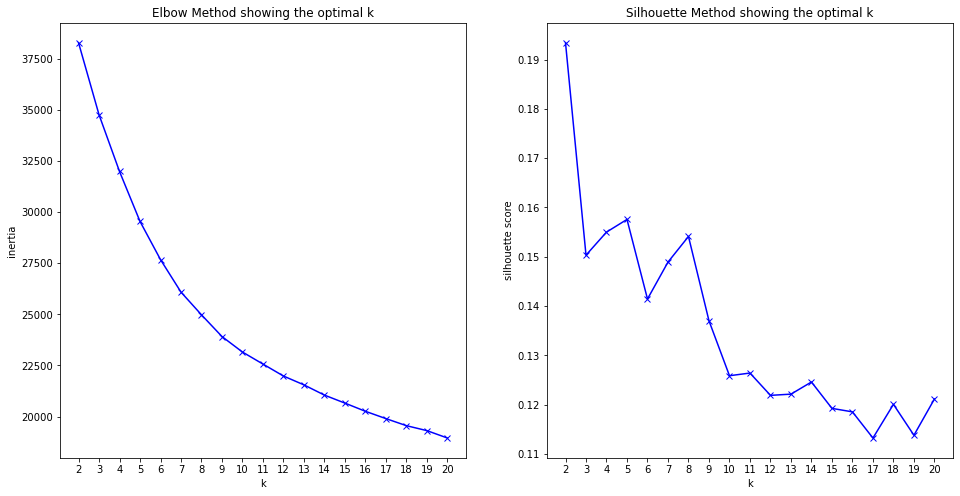

In [18]:
#We start with 2 because we need at least 2 groups to compare 
#From 2 to 21 because we want to compare the performance of our models with up to 20 songs
K = range(2, 21)
inertia = [] #Store the inertia value of every model
silhouette = [] #Store the silhouette score of every model

for k in K:
    print("Training a K-Means model with {} neighbours! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,
                    n_init = 10, #Train 10 models, the function will store only 1 as a pickle file.
                    random_state=1234,
                    verbose =1) #Display progress messages
    kmeans.fit(X_scaled_df)
    filename = "/Users/Hector_Martin/Documents/Labs/music_recommender_project/models/kmeans_" + str(k) + ".pickle" #CHANGE THE PATH TO MINE
    with open(filename, "wb") as file:
        pickle.dump(kmeans,file)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Elbow Method:
fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(K, inertia, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('inertia')
ax[0].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[0].set_title('Elbow Method showing the optimal k')

#Silhouette Method:
ax[1].plot(K, silhouette, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('silhouette score')
ax[1].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[1].set_title('Silhouette Method showing the optimal k')

### Loading the scaler and the best model:

In [19]:
def load(filename = "filename.pickle"): #if I don't specify the name of the file it's going to be 'filename.pickle'
    try: 
        with open(filename, "rb") as file: 
            return pickle.load(file) 
    except FileNotFoundError: 
        print("File not found!") 

#### Loading the scaler from a pickle file

In [22]:
scaler = load("scalers/standardscaler.pickle")
scaler

StandardScaler()

#### Loading the best_model from a pickle file:
Based on the Elbow method graphic we plotted, we can determine that the best model is the one with 8Ks.

In [23]:
best_model = load("models/kmeans_8.pickle")